# Bank Authenticaton notes using Spark

### Importing libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.mllib.classification import LogisticRegressionWithLBFGS,SVMWithSGD,LogisticRegressionWithSGD,NaiveBayes
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql import SQLContext
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score

### Creating the Spark Context and Starting the Spark Session

<b>SparkContext</b> is the entry point to the services of Apache Spark (execution engine) and so the heart of a Spark application. In fact, you can consider an application a Spark application only when it uses a SparkContext (directly or indirectly).

<b>SparkSession</b> provides a single point of entry to interact with underlying Spark functionality and allows programming Spark with Dataframe and Dataset APIs. All the functionality available with **sparkContext are also available in sparkSession.**

Creating and Running SparkSession.

In [2]:
sc = SparkContext()
spark = SparkSession(sc)

### Importing data

In [3]:
dataset=pd.read_csv('authentication.csv')

Data is being imported from the CSV(Comma seperated value) into the <b>DataFrame <u>dataset.</u></b>

Let's find out the shape of the dataset.

In [4]:
print(dataset.shape)

(1372, 5)


We find that there are **1372** rows and **5** columns.

The columns of the dataset are as follows: - 

In [5]:
print(dataset.columns)

Index([u'Variance', u'Skewness', u'Curtosis', u'Entropy', u'Class'], dtype='object')


Let's find out the top 10 values of the dataset.

In [6]:
dataset.head(10)

,Variance,Skewness,Curtosis,Entropy,Class
0,3.62160,8.6661,-2.80730,-0.44699,0
1,4.54590,8.1674,-2.45860,-1.46210,0
2,3.86600,-2.6383,1.92420,0.10645,0
3,3.45660,9.5228,-4.01120,-3.59440,0
4,0.32924,-4.4552,4.57180,-0.98880,0
5,4.36840,9.6718,-3.96060,-3.16250,0
6,3.59120,3.0129,0.72888,0.56421,0
7,2.09220,-6.8100,8.46360,-0.60216,0
8,3.20320,5.7588,-0.75345,-0.61251,0
9,1.53560,9.1772,-2.27180,-0.73535,0


Let's find out the last 10 values of the dataset.

In [7]:
dataset.tail(10)

,Variance,Skewness,Curtosis,Entropy,Class
1362,-2.16680,1.59330,0.045122,-1.67800,1
1363,-1.16670,-1.42370,2.924100,0.66119,1
1364,-2.83910,-6.63000,10.484900,-0.42113,1
1365,-4.50460,-5.81260,10.886700,-0.52846,1
1366,-2.41000,3.74330,-0.402150,-1.29530,1
1367,0.40614,1.34920,-1.450100,-0.55949,1
1368,-1.38870,-4.87730,6.477400,0.34179,1
1369,-3.75030,-13.45860,17.593200,-2.77710,1
1370,-3.56370,-8.38270,12.393000,-1.28230,1
1371,-2.54190,-0.65804,2.684200,1.19520,1


Here we found that that there are 4 feature variables: - **Variance** , **Skewness** , **Curtosis** , **Entropy**

The **target variable is: - class**

class = 0 - **Bank notes are fake.**

class = 1 - **Bank notes are real.**

### Data Preprocessing

Finding more information about the dataset.

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
Variance    1372 non-null float64
Skewness    1372 non-null float64
Curtosis    1372 non-null float64
Entropy     1372 non-null float64
Class       1372 non-null int64
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


We found that all the values of the dataset are **float** values and there is <u>no</u> **null** value in the dataset.

**Let's find out the correlation in the labels with them and plot the graph.**

In [9]:
corr = dataset.corr()
print(corr)
corr.style.background_gradient(cmap='coolwarm')

          Variance  Skewness  Curtosis   Entropy     Class
Variance  1.000000  0.264026 -0.380850  0.276817 -0.724843
Skewness  0.264026  1.000000 -0.786895 -0.526321 -0.444688
Curtosis -0.380850 -0.786895  1.000000  0.318841  0.155883
Entropy   0.276817 -0.526321  0.318841  1.000000 -0.023424
Class    -0.724843 -0.444688  0.155883 -0.023424  1.000000


,Variance,Skewness,Curtosis,Entropy,Class
Variance,1,0.264026,-0.38085,0.276817,-0.724843
Skewness,0.264026,1,-0.786895,-0.526321,-0.444688
Curtosis,-0.38085,-0.786895,1,0.318841,0.155883
Entropy,0.276817,-0.526321,0.318841,1,-0.0234237
Class,-0.724843,-0.444688,0.155883,-0.0234237,1


We find that the two variables: - **Variance** and **Skewness** has the **maximum** effect on **Class label.** We will plot all the graphs considering these two variables.

Plotting Box Plot for generating **Q1** to **Q3** quartile values of each dataset.

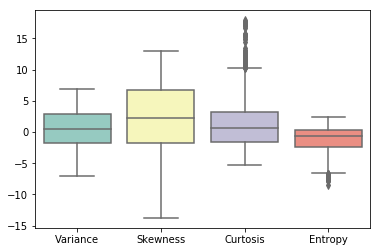

In [10]:
ax = sns.boxplot(data=dataset.iloc[:,:4], palette="Set3")
plt.rcParams['figure.figsize'] = [10, 5]

<br>Finding all statistically values for each **Labels** in dataset.

In [11]:
dataset.describe()

,Variance,Skewness,Curtosis,Entropy,Class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


### Converting Pandas Dataframe to Spark DataFrame

We are converting the **Pandas Dataframe** to the **Spark DataFrame**.

In [12]:
sqlContext = SQLContext(sc)
spark_df = sqlContext.createDataFrame(dataset)

Let's find out the top 10 values of the dataset in the sparkDataFrame

In [13]:
spark_df.show(10)

+-------------------+--------+--------+--------------------+-----+
|           Variance|Skewness|Curtosis|             Entropy|Class|
+-------------------+--------+--------+--------------------+-----+
|             3.6216|  8.6661| -2.8073|-0.44698999999999994|    0|
|             4.5459|  8.1674| -2.4586|             -1.4621|    0|
|              3.866| -2.6383|  1.9242|             0.10645|    0|
|             3.4566|  9.5228| -4.0112|             -3.5944|    0|
|0.32924000000000003| -4.4552|  4.5718|             -0.9888|    0|
|             4.3684|  9.6718| -3.9606|             -3.1625|    0|
|             3.5912|  3.0129| 0.72888|             0.56421|    0|
|             2.0922|   -6.81|  8.4636|            -0.60216|    0|
|             3.2032|  5.7588|-0.75345|            -0.61251|    0|
|             1.5356|  9.1772| -2.2718|            -0.73535|    0|
+-------------------+--------+--------+--------------------+-----+
only showing top 10 rows



Finding out whether the **Class** column is **undersampled** or not.

In [14]:
spark_count=spark_df.groupBy("Class").count()
spark_count.show()

+-----+-----+
|Class|count|
+-----+-----+
|    0|  762|
|    1|  610|
+-----+-----+



Since there are:- 

0- **762** counts

1- **610** counts

So we found that there are **no undersampling** in the dataset.


Making the **SQL table** of the spark DataFrame and store the table.

In [15]:
spark_df.registerTempTable("spark_df")

In [16]:
spark_df.show(10)

+-------------------+--------+--------+--------------------+-----+
|           Variance|Skewness|Curtosis|             Entropy|Class|
+-------------------+--------+--------+--------------------+-----+
|             3.6216|  8.6661| -2.8073|-0.44698999999999994|    0|
|             4.5459|  8.1674| -2.4586|             -1.4621|    0|
|              3.866| -2.6383|  1.9242|             0.10645|    0|
|             3.4566|  9.5228| -4.0112|             -3.5944|    0|
|0.32924000000000003| -4.4552|  4.5718|             -0.9888|    0|
|             4.3684|  9.6718| -3.9606|             -3.1625|    0|
|             3.5912|  3.0129| 0.72888|             0.56421|    0|
|             2.0922|   -6.81|  8.4636|            -0.60216|    0|
|             3.2032|  5.7588|-0.75345|            -0.61251|    0|
|             1.5356|  9.1772| -2.2718|            -0.73535|    0|
+-------------------+--------+--------+--------------------+-----+
only showing top 10 rows



In [17]:
sqlContext.sql("select * from spark_df").toPandas().head(10)

,Variance,Skewness,Curtosis,Entropy,Class
0,3.62160,8.6661,-2.80730,-0.44699,0
1,4.54590,8.1674,-2.45860,-1.46210,0
2,3.86600,-2.6383,1.92420,0.10645,0
3,3.45660,9.5228,-4.01120,-3.59440,0
4,0.32924,-4.4552,4.57180,-0.98880,0
5,4.36840,9.6718,-3.96060,-3.16250,0
6,3.59120,3.0129,0.72888,0.56421,0
7,2.09220,-6.8100,8.46360,-0.60216,0
8,3.20320,5.7588,-0.75345,-0.61251,0
9,1.53560,9.1772,-2.27180,-0.73535,0


### Converting DataFrame to numpy arrays.

**Numpy arrays** - A numpy array is a grid of values, all of the same type, and is indexed by a tuple of nonnegative integers. The number of dimensions is the rank of the array; the shape of an array is a tuple of integers giving the size of the array along each dimension.

In [18]:
X=dataset.iloc[:,0:4].values
y=dataset.iloc[:,-1].values
print(X)
print(y)

[[  3.6216    8.6661   -2.8073   -0.44699]
 [  4.5459    8.1674   -2.4586   -1.4621 ]
 [  3.866    -2.6383    1.9242    0.10645]
 ...
 [ -3.7503  -13.4586   17.5932   -2.7771 ]
 [ -3.5637   -8.3827   12.393    -1.2823 ]
 [ -2.5419   -0.65804   2.6842    1.1952 ]]
[0 0 0 ... 1 1 1]


**Splitting the array into train and test sets.**

In [19]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=3)


**Converting** the values in numpy arrays into Labeled Point to represent each point in labels which will be used in training the spark model.

**Labeled Point: -** Class that represents the features and labels of a data point.

Parameters:	
- label – Label for this data point.
- features – Vector of features for this point (NumPy array, list, pyspark.mllib.linalg.SparseVector, or scipy.sparse column matrix).


In [20]:
data=[]
for i in range(len(X_train)):
    data.append(LabeledPoint(y_train[i],X_train[i]))

Printing the **top 10** values of the labeled point of all the data points.

In [21]:
print(data[:10])

[LabeledPoint(0.0, [2.9719,6.8369,-0.2702,0.71291]), LabeledPoint(1.0, [-0.90784,-7.9026,6.7807,0.34179]), LabeledPoint(1.0, [-0.97325,-6.4168,5.6026,1.0323]), LabeledPoint(1.0, [-1.3414,-1.9162,-0.15538,-0.11984000000000002]), LabeledPoint(1.0, [-0.0012852,0.13863,-0.19651,0.0081754]), LabeledPoint(0.0, [-1.8411,10.8306,2.7689999999999997,-3.0901]), LabeledPoint(1.0, [-1.8974,3.5074,-1.7842,-3.8491]), LabeledPoint(1.0, [-2.3629,-0.10554000000000001,1.9336,1.1358]), LabeledPoint(1.0, [-2.3147,3.6668,-0.6969,-1.2474]), LabeledPoint(0.0, [1.9358,8.1654,-0.023425,-2.2586])]


### Training the spark models:-

We are going to use the **pyspark.mllib** module of the pyspark module to traint the spark model by clustering oof the data points.

Creating dictionary **dic** - 

- **Key**: Type of classification model used.
- **Value**: Accuracy of the model.

In [22]:
dic={}

### Logistic Regression With LBFGS

The confusion matrix is:

[[168   0]
 [  8  99]]

The accuracy of the Logistic Regression With LBFGS is: 97.0909090909%


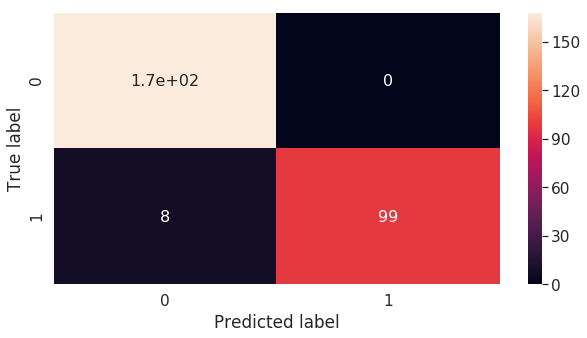

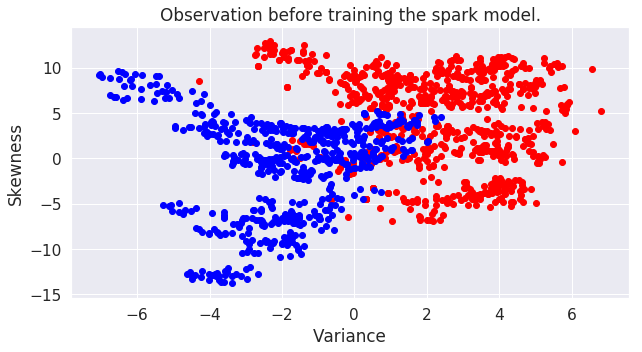

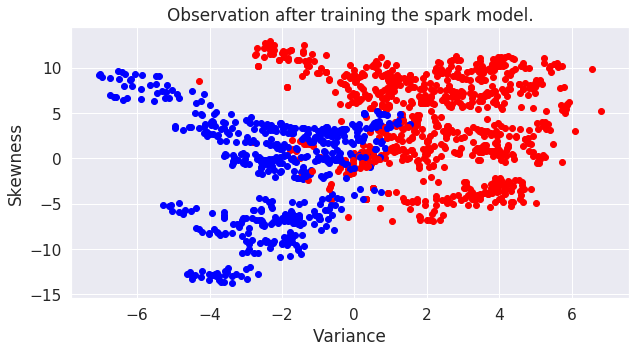

In [23]:
lrm1 = LogisticRegressionWithLBFGS.train(sc.parallelize(data), iterations=1000)
y_predict=lrm1.predict(sc.parallelize(X_test)).collect()
cm=confusion_matrix(y_true=y_test,y_pred=y_predict)
acc=accuracy_score(y_test,y_predict)
dic["Logistic Regression With LBFGS"]=acc
print("The confusion matrix is:")
print("")
print(cm)
print("")
print("The accuracy of the {} is: {}%".format("Logistic Regression With LBFGS",acc*100))
plt.figure(1)
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16})
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.figure(2)

for i in range(len(X)):
    if(y[i]==1):
        plt.scatter(X[i][0],X[i][1],color="blue")
    if(y[i]==0):
        plt.scatter(X[i][0],X[i][1],color="red")

plt.title("Observation before training the spark model.")
plt.xlabel("Variance")
plt.ylabel("Skewness")
plt.show()
y_whole=lrm1.predict(sc.parallelize(X)).collect()
plt.figure(3)
for i in range(len(X)):
    if(y_whole[i]==1):
        plt.scatter(X[i][0],X[i][1],color="blue")
    if(y_whole[i]==0):
        plt.scatter(X[i][0],X[i][1],color="red")
plt.title("Observation after training the spark model.")
plt.xlabel("Variance")
plt.ylabel("Skewness")
plt.show()

### Logistic Regression With SGD

The confusion matrix is:

[[168   0]
 [  8  99]]

The accuracy of the Logistic Regression With SGD is: 97.0909090909%
The Red points are : Fake
The Blue points are: Real


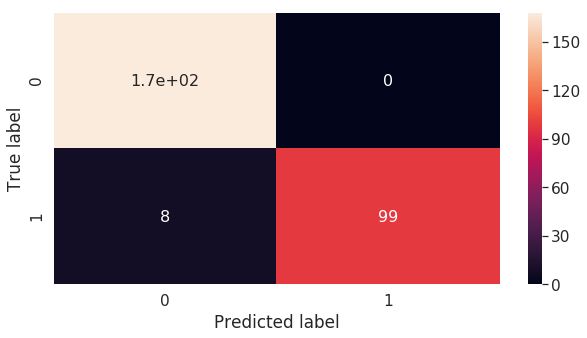

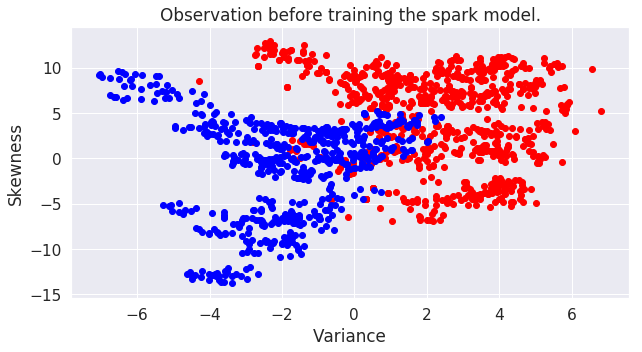

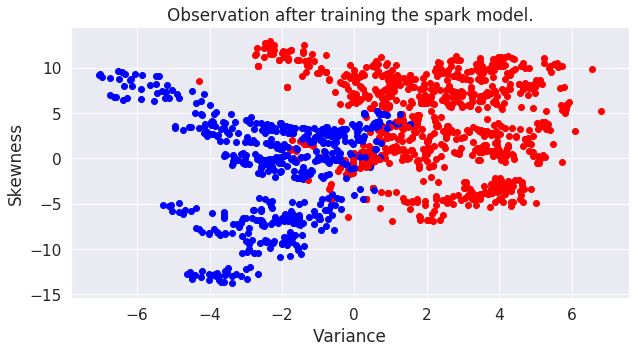

In [24]:
lrm2 = LogisticRegressionWithSGD.train(sc.parallelize(data), iterations=1000)
y_predict=lrm2.predict(sc.parallelize(X_test)).collect()
cm=confusion_matrix(y_true=y_test,y_pred=y_predict)
acc=accuracy_score(y_test,y_pred=y_predict)
dic["Logistic Regression With SGD"]=acc
print("The confusion matrix is:")
print("")
print(cm)
print("")
print("The accuracy of the {} is: {}%".format("Logistic Regression With SGD",acc*100))
plt.figure(1)
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16})
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.figure(2)
for i in range(len(X)):
    if(y[i]==1):
        plt.scatter(X[i][0],X[i][1],color="blue")
    if(y[i]==0):
        plt.scatter(X[i][0],X[i][1],color="red")
print("The Red points are : Fake")
print("The Blue points are: Real")
plt.title("Observation before training the spark model.")
plt.xlabel("Variance")
plt.ylabel("Skewness")
plt.show()
y_whole=lrm2.predict(sc.parallelize(X)).collect()
plt.figure(3)
for i in range(len(X)):
    if(y_whole[i]==1):
        plt.scatter(X[i][0],X[i][1],color="blue")
    if(y_whole[i]==0):
        plt.scatter(X[i][0],X[i][1],color="red")
plt.title("Observation after training the spark model.")
plt.xlabel("Variance")
plt.ylabel("Skewness")
plt.show()

### SVM With SGD

The confusion matrix is:

[[168   0]
 [  9  98]]

The accuracy of the SVM With SGD is: 96.7272727273%
The Red points are : Fake
The Blue points are: Real


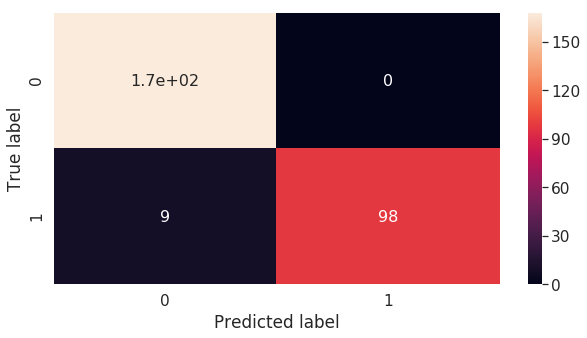

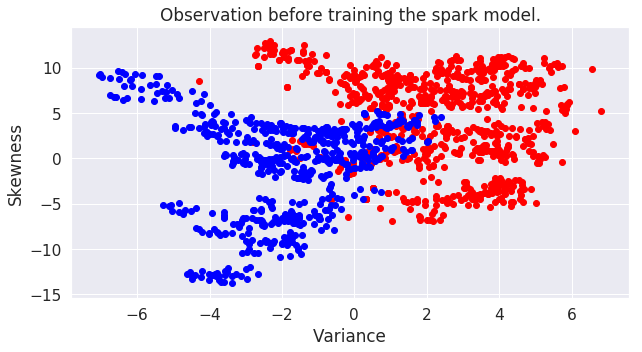

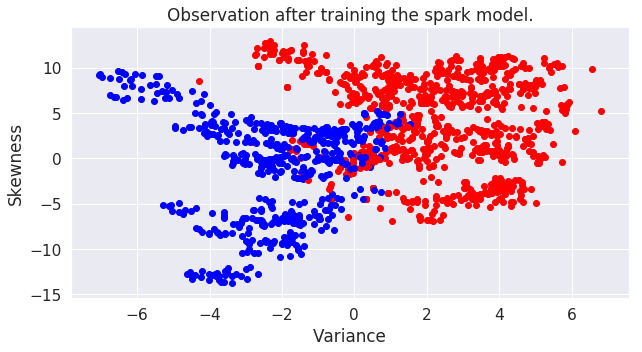

In [25]:
lrm3 = SVMWithSGD.train(sc.parallelize(data), iterations=1000)
y_predict=lrm3.predict(sc.parallelize(X_test)).collect()
cm=confusion_matrix(y_true=y_test,y_pred=y_predict)
acc=accuracy_score(y_test,y_pred=y_predict)
dic["SVM With SGD"]=acc
print("The confusion matrix is:")
print("")
print(cm)
print("")
print("The accuracy of the {} is: {}%".format("SVM With SGD",acc*100))
plt.figure(1)
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16})
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.figure(2)
for i in range(len(X)):
    if(y[i]==1):
        plt.scatter(X[i][0],X[i][1],color="blue")
    if(y[i]==0):
        plt.scatter(X[i][0],X[i][1],color="red")
print("The Red points are : Fake")
print("The Blue points are: Real")
plt.title("Observation before training the spark model.")
plt.xlabel("Variance")
plt.ylabel("Skewness")
plt.show()
y_whole=lrm3.predict(sc.parallelize(X)).collect()
plt.figure(3)
for i in range(len(X)):
    if(y_whole[i]==1):
        plt.scatter(X[i][0],X[i][1],color="blue")
    if(y_whole[i]==0):
        plt.scatter(X[i][0],X[i][1],color="red")
plt.title("Observation after training the spark model.")
plt.xlabel("Variance")
plt.ylabel("Skewness")
plt.show()

### RANDOM FOREST

The confusion matrix is:

[[158  10]
 [  2 105]]

The accuracy of the Random Forest is: 95.6363636364%
The Red points are : Fake
The Blue points are: Real


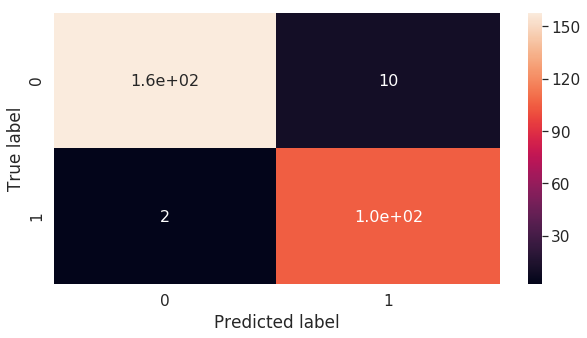

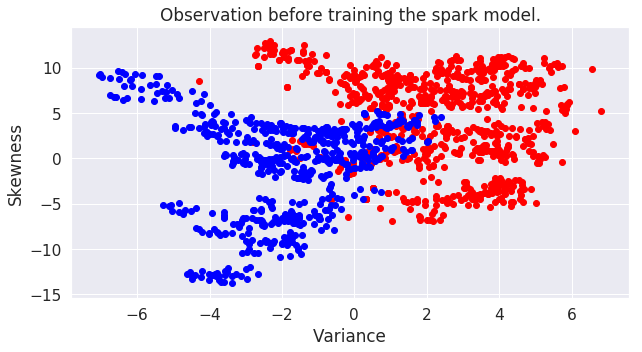

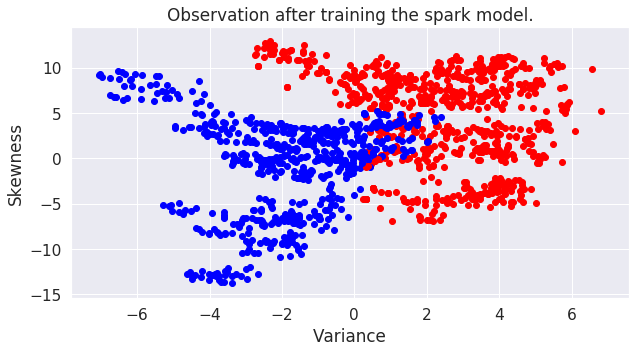

In [26]:
from pyspark.mllib.tree import RandomForest
lrm4 = RandomForest.trainClassifier(sc.parallelize(data),2,{},100)
y_predict=lrm4.predict(sc.parallelize(X_test)).collect()
cm=confusion_matrix(y_true=y_test,y_pred=y_predict)
acc=accuracy_score(y_test,y_pred=y_predict)
dic["Random Forest"]=acc
print("The confusion matrix is:")
print("")
print(cm)
print("")
print("The accuracy of the {} is: {}%".format("Random Forest",acc*100))
plt.figure(1)
sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True,annot_kws={"size": 16})
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.figure(2)
for i in range(len(X)):
    if(y[i]==1):
        plt.scatter(X[i][0],X[i][1],color="blue")
    if(y[i]==0):
        plt.scatter(X[i][0],X[i][1],color="red")
print("The Red points are : Fake")
print("The Blue points are: Real")
plt.title("Observation before training the spark model.")
plt.xlabel("Variance")
plt.ylabel("Skewness")
plt.show()
y_whole=lrm4.predict(sc.parallelize(X)).collect()
plt.figure(3)
for i in range(len(X)):
    if(y_whole[i]==1):
        plt.scatter(X[i][0],X[i][1],color="blue")
    if(y_whole[i]==0):
        plt.scatter(X[i][0],X[i][1],color="red")
plt.title("Observation after training the spark model.")
plt.xlabel("Variance")
plt.ylabel("Skewness")
plt.show()

**Comparing the accuracy of the all the models with each other.**

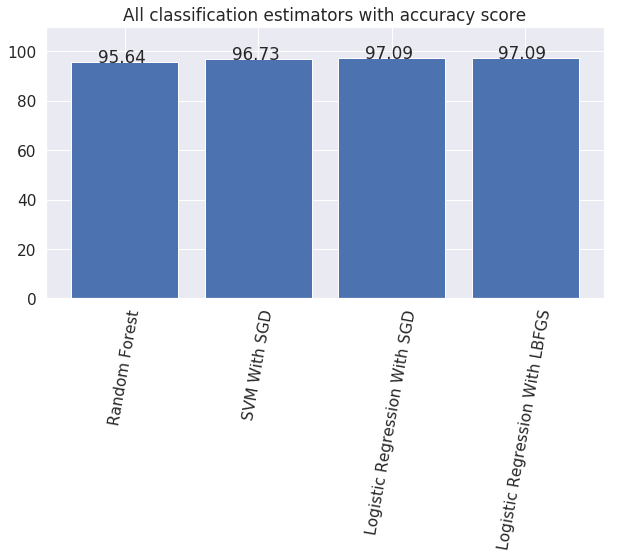

In [27]:
Estimators=[]
Accuracy=[]
for i in dic:
    Estimators.append(i)
    Accuracy.append(dic[i]*100)
d={'Estimators':Estimators,"Accuracy":Accuracy}
df=pd.DataFrame(data=d)
plt.rcParams['figure.figsize'] = [10, 5]
plt.ylim(0,110)
plt.title("All classification estimators with accuracy score")
bars=plt.bar(x=Estimators,height=Accuracy)
for bar in bars:
    yval = round(bar.get_height(),2)
    plt.text(bar.get_x()+0.2, round((yval + .005),2), yval)
plt.xticks(rotation=80)
plt.show()

### Checking of the Unlabeled Notes

Since We can deduce that the **notes which are real and considered as fake** has a huge impact on the economy as the real notes are being discarded considered as fake notes. i.e.

**Actual Value of note: - 1**

**Predicted Value of note: - 0**

We will check the notes which are labeled as fakes and are actually real by the different models and determine whether the different models capture and labeled these notes correctly.

### Using Logistic Regression With LBFGS

In [28]:
y_wrong_lbfgs=[]
y_whole_lbfgs=lrm1.predict(sc.parallelize(X_test)).collect()
for i in range(len(y_whole_lbfgs)):
    if(y_test[i]==1 and y_whole_lbfgs[i]==0):
        y_wrong_lbfgs.append(X_test[i])
y_wrong_lbfgs=np.array(y_wrong_lbfgs)
print(y_wrong_lbfgs)
print("*"*45)

[[ 0.24394   1.4733   -1.4192   -0.58535 ]
 [ 0.50225   0.65388  -1.1793    0.39998 ]
 [ 0.518     0.25865  -0.84085   0.96118 ]
 [ 0.84546   3.4826   -3.6307   -1.3961  ]
 [ 1.3403    4.1323   -4.7018   -2.5987  ]
 [ 0.12126   0.22347  -0.47327   0.97024 ]
 [-1.4375   -1.8624    4.026     0.55127 ]
 [ 0.66365  -0.045533 -0.18794   0.23447 ]]
*********************************************


### Using Logistic Regression With SGD

In [29]:
y_wrong_sgd=[]
y_whole_sgd=lrm2.predict(sc.parallelize(y_wrong_lbfgs)).collect()
for i in range(len(y_whole_sgd)):
    if(y_whole_sgd[i]==0):
        y_wrong_sgd.append(y_wrong_lbfgs[i])
y_wrong_sgd=np.array(y_wrong_sgd)
print(y_wrong_sgd)
print("*"*45)

[[ 0.24394   1.4733   -1.4192   -0.58535 ]
 [ 0.50225   0.65388  -1.1793    0.39998 ]
 [ 0.518     0.25865  -0.84085   0.96118 ]
 [ 0.84546   3.4826   -3.6307   -1.3961  ]
 [ 1.3403    4.1323   -4.7018   -2.5987  ]
 [ 0.12126   0.22347  -0.47327   0.97024 ]
 [ 0.66365  -0.045533 -0.18794   0.23447 ]]
*********************************************


### Using SVM With SGD

In [30]:
y_wrong_svm=[]
y_whole_svm=lrm3.predict(sc.parallelize(y_wrong_sgd)).collect()
for i in range(len(y_whole_svm)):
    if(y_whole_svm[i]==0):
        y_wrong_svm.append(y_wrong_sgd[i])
y_wrong_svm=np.array(y_wrong_svm)
print(y_wrong_svm)
print("*"*45)

[[ 0.24394   1.4733   -1.4192   -0.58535 ]
 [ 0.50225   0.65388  -1.1793    0.39998 ]
 [ 0.518     0.25865  -0.84085   0.96118 ]
 [ 0.84546   3.4826   -3.6307   -1.3961  ]
 [ 1.3403    4.1323   -4.7018   -2.5987  ]
 [ 0.12126   0.22347  -0.47327   0.97024 ]
 [ 0.66365  -0.045533 -0.18794   0.23447 ]]
*********************************************


### Using Random Forest

In [31]:
y_wrong_forest=[]
y_whole_forest=lrm4.predict(sc.parallelize(y_wrong_svm)).collect()
for i in range(len(y_whole_forest)):
    if(y_whole_forest[i]==0):
        y_wrong_forest.append(y_wrong_svm[i])
y_wrong_forest=np.array(y_wrong_forest)
print(y_wrong_forest)
print("*"*45)

[[ 0.66365  -0.045533 -0.18794   0.23447 ]]
*********************************************


## We can conclude that using random forest we can detect most of the real notes which are lalebeled as fake notes and will be discarded.